In [14]:
import pandas as pd
data = pd.read_csv("England.csv")

In [16]:
data.head()

,Date,Season,HomeTeam,AwayTeam,FTH Goals,FTA Goals,FT Result,HTH Goals,HTA Goals,HT Result,...,H Fouls,A Fouls,H Corners,A Corners,H Yellow,A Yellow,H Red,A Red,Display_Order,League
0,16/01/2025,2024/25,Ipswich Town,Brighton & Hove Albion,0,2,A,0.0,1.0,A,...,13.0,14.0,1.0,9.0,2.0,2.0,0.0,0.0,20250116,Premier League
1,16/01/2025,2024/25,Man United,Southampton,3,1,H,0.0,1.0,A,...,7.0,10.0,4.0,4.0,1.0,3.0,0.0,0.0,20250116,Premier League
2,15/01/2025,2024/25,Everton,Aston Villa,0,1,A,0.0,0.0,D,...,17.0,10.0,8.0,5.0,2.0,1.0,0.0,0.0,20250115,Premier League
3,15/01/2025,2024/25,Leicester,Crystal Palace,0,2,A,0.0,0.0,D,...,7.0,6.0,4.0,3.0,0.0,0.0,0.0,0.0,20250115,Premier League
4,15/01/2025,2024/25,Newcastle,Wolves,3,0,H,1.0,0.0,H,...,10.0,13.0,4.0,2.0,0.0,2.0,0.0,0.0,20250115,Premier League


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12153 entries, 0 to 12152
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           12153 non-null  object 
 1   Season         12153 non-null  object 
 2   HomeTeam       12153 non-null  object 
 3   AwayTeam       12153 non-null  object 
 4   FTH Goals      12153 non-null  int64  
 5   FTA Goals      12153 non-null  int64  
 6   FT Result      12153 non-null  object 
 7   HTH Goals      11229 non-null  float64
 8   HTA Goals      11229 non-null  float64
 9   HT Result      11229 non-null  object 
 10  Referee        9329 non-null   object 
 11  H Shots        9329 non-null   float64
 12  A Shots        9329 non-null   float64
 13  H SOT          9329 non-null   float64
 14  A SOT          9329 non-null   float64
 15  H Fouls        9329 non-null   float64
 16  A Fouls        9329 non-null   float64
 17  H Corners      9329 non-null   float64
 18  A Corn

In [20]:
required_cols = ['FT Result', 'H Shots', 'A Shots', 'H SOT', 'A SOT', 'H Fouls', 'A Fouls', 'H Corners', 'A Corners', 'H Yellow', 'A Yellow', 'H Red', 'A Red']

In [22]:
df_cleaned = df.dropna(subset=required_cols).copy()

In [24]:
df_cleaned['Result'] = df_cleaned['FT Result'].map({'A': 0, 'D': 1, 'H': 2})

In [26]:
import numpy as np

df_cleaned['ShotsOnTargetDiff'] = df_cleaned['H SOT'] - df_cleaned['A SOT']
df_cleaned['ShotsDiff'] = df_cleaned['H Shots'] - df_cleaned['A Shots']
df_cleaned['CornersDiff'] = df_cleaned['H Corners'] - df_cleaned['A Corners']
df_cleaned['FoulsDiff'] = df_cleaned['H Fouls'] - df_cleaned['A Fouls']
df_cleaned['YellowCardDiff'] = df_cleaned['H Yellow'] - df_cleaned['A Yellow']
df_cleaned['RedCardDiff'] = df_cleaned['H Red'] - df_cleaned['A Red']

features = ['ShotsOnTargetDiff', 'ShotsDiff', 'CornersDiff', 
            'FoulsDiff', 'YellowCardDiff', 'RedCardDiff']
X = df_cleaned[features]
y = df_cleaned['Result']

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

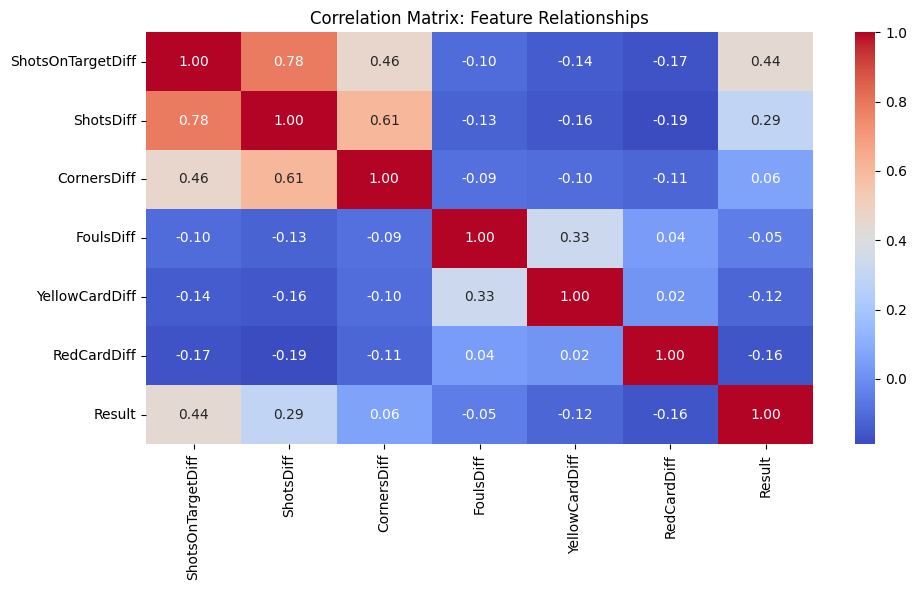

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
corr_matrix = df_cleaned[features + ['Result']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix: Feature Relationships")
plt.tight_layout()
plt.show()

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

models_to_test = {
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', random_state=42)
}

for name, model in models_to_test.items():
    model.fit(X_train_scaled, y_train)
    pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, pred)
    print(f"{name} Baseline Accuracy: {acc:.4f}")

Logistic Regression Baseline Accuracy: 0.5697
Random Forest Baseline Accuracy: 0.5236
XGBoost Baseline Accuracy: 0.5573


In [44]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  
    'solver': ['lbfgs']
}

grid_search = GridSearchCV(LogisticRegression(max_iter=2000, random_state=42), 
                           param_grid, cv=5, n_jobs=-1, verbose=0)

grid_search.fit(X_train_scaled, y_train)
best_model = grid_search.best_estimator_

In [50]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import shap

y_pred_final = best_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred_final, target_names=['Away', 'Draw', 'Home']))

              precision    recall  f1-score   support

        Away       0.54      0.57      0.56       548
        Draw       0.00      0.00      0.00       462
        Home       0.58      0.87      0.70       856

    accuracy                           0.57      1866
   macro avg       0.37      0.48      0.42      1866
weighted avg       0.43      0.57      0.48      1866



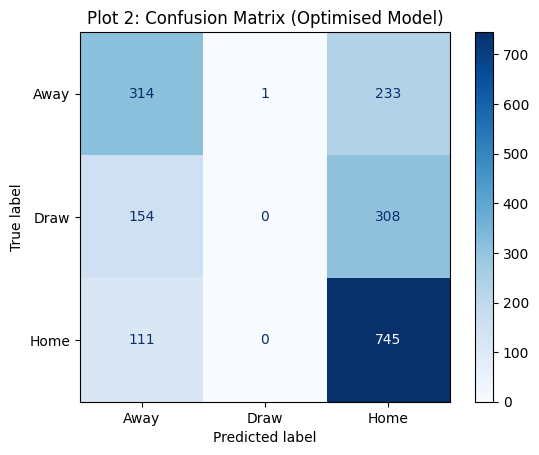

In [52]:
ConfusionMatrixDisplay.from_estimator(best_model, X_test_scaled, y_test, 
                                      display_labels=['Away', 'Draw', 'Home'], cmap='Blues')
plt.title("Plot 2: Confusion Matrix (Optimised Model)")
plt.show()

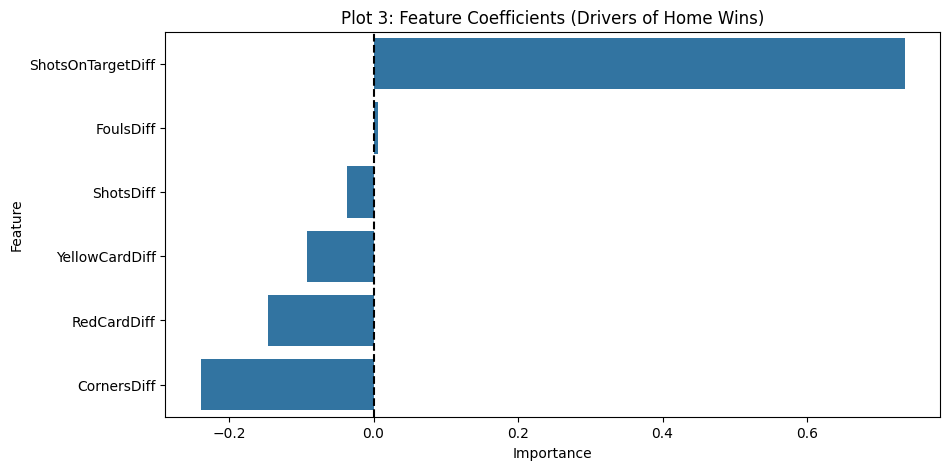

In [54]:
importance = best_model.coef_[2] # Focus on Home Win class
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importance})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title("Plot 3: Feature Coefficients (Drivers of Home Wins)")
plt.axvline(x=0, color='black', linestyle='--')
plt.show()

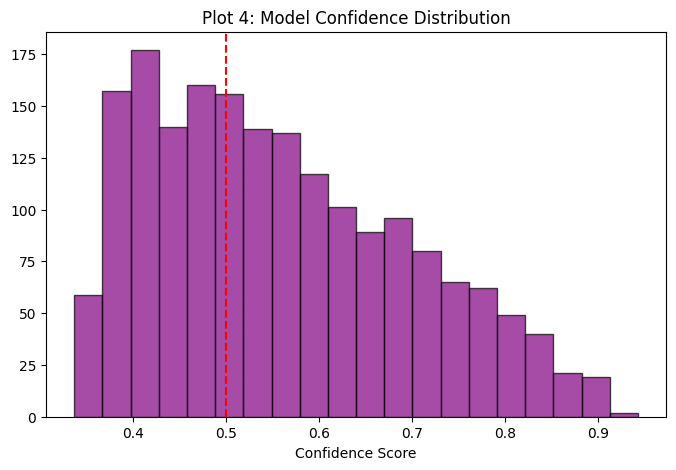

In [55]:
probs = best_model.predict_proba(X_test_scaled)
confidence_scores = probs.max(axis=1)

plt.figure(figsize=(8, 5))
plt.hist(confidence_scores, bins=20, color='purple', edgecolor='black', alpha=0.7)
plt.title("Plot 4: Model Confidence Distribution")
plt.xlabel("Confidence Score")
plt.axvline(x=0.5, color='red', linestyle='--')
plt.show()

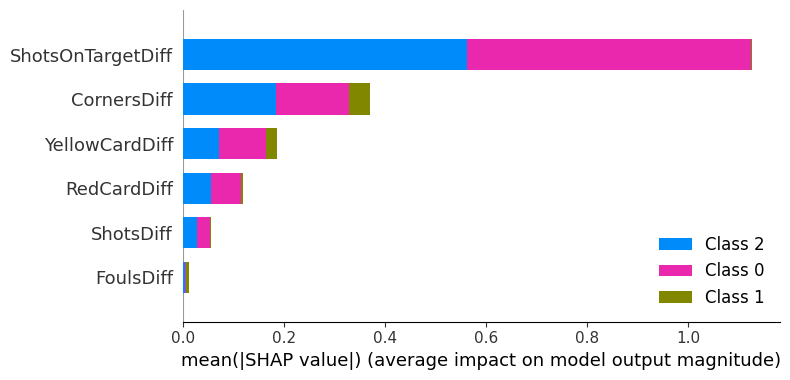

In [58]:
masker = shap.maskers.Independent(data=X_test_scaled)
explainer = shap.LinearExplainer(best_model, masker=masker)
shap_values = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values, X_test_scaled, feature_names=features, plot_type="bar")

In [63]:
results_table = df_cleaned.loc[X_test.index].copy()
results_table['Predicted_Code'] = y_pred_final
outcome_map = {0: 'Away Win', 1: 'Draw', 2: 'Home Win'}
results_table['Prediction'] = results_table['Predicted_Code'].map(outcome_map)
results_table['Actual'] = results_table['Result'].map(outcome_map)
results_table['Correct?'] = results_table['Prediction'] == results_table['Actual']
final_view = results_table[['Date', 'HomeTeam', 'AwayTeam', 'H Shots', 'A Shots', 'Prediction', 'Actual', 'Correct?']]
print(final_view.head(10))

arsenal_games = final_view[(final_view['HomeTeam'] == 'Arsenal') | (final_view['AwayTeam'] == 'Arsenal')]
print(arsenal_games.head())

arsenal_accuracy = arsenal_games['Correct?'].mean()
print(f"\nModel Accuracy for Arsenal games: {arsenal_accuracy:.2%}")

            Date        HomeTeam     AwayTeam  H Shots  A Shots Prediction  \
2302  26/12/2018       Tottenham  Bournemouth     10.0     14.0   Home Win   
4784   6/05/2012          Wolves      Everton      7.0     18.0   Away Win   
8179  17/08/2003           Leeds    Newcastle      8.0     19.0   Away Win   
3909   3/11/2014  Crystal Palace   Sunderland      9.0      8.0   Away Win   
6507  15/12/2007      Portsmouth    Tottenham      9.0     12.0   Home Win   
5214   9/04/2011          Wolves      Everton     11.0      9.0   Home Win   
2690  17/12/2017       West Brom   Man United     12.0      8.0   Home Win   
4030   3/05/2014           Stoke       Fulham     23.0     10.0   Home Win   
1479  27/02/2021       West Brom     Brighton      6.0     15.0   Away Win   
2533  18/04/2018     Bournemouth   Man United     13.0     13.0   Away Win   

        Actual  Correct?  
2302  Home Win      True  
4784      Draw     False  
8179      Draw     False  
3909  Away Win      True  
6507  